In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from sklearn.decomposition import PCA


%matplotlib inline


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Import Data

In [2]:
# Read in CSV
file = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

raw_dataset = pd.read_csv(file, sep=',')

dataset = raw_dataset.copy()
display(dataset.head())

print(dataset.columns)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_r

## Filtering and Cleaning

In [73]:
#relevant_columns = ['iso_code', 'location', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'life_expectancy', 'human_development_index']

relevant_columns = ['iso_code', 'location', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'life_expectancy', 'human_development_index']

def clean_data(relevant_columns, dataset):
    # Keep only relevant data
    dataset = dataset[relevant_columns]
    
    # Keep only one record for each country
    country_data = dataset.drop_duplicates(subset='iso_code').reset_index(drop=True)

    # For now, we'll deal with missing values as follows:
    # 1. Drop all rows with 5 or more NaNs
    # 2. For remaining rows, drop all columns with NaN

    nulls_per_row = country_data.isnull().sum(axis=1)
    rows_to_drop = nulls_per_row >= 3
    full_country_data = country_data[~rows_to_drop]
    full_country_data = full_country_data.dropna(axis=1)
    full_country_data.set_index('iso_code', inplace=True)

    # Try dropping everybody with nulls
#     nulls_per_row = country_data.isnull().sum(axis=1)
#     rows_to_drop = nulls_per_row >= 1
#     full_country_data = country_data[~rows_to_drop]
#     full_country_data.set_index('iso_code', inplace=True)
    
    return full_country_data
    

In [74]:
full_country_data = clean_data(relevant_columns, dataset)
full_country_data

,location,cardiovasc_death_rate,diabetes_prevalence,life_expectancy
iso_code,,,,
ALB,Albania,304.195,10.08,78.57
DZA,Algeria,278.364,6.73,76.88
AND,Andorra,109.135,7.97,83.73
ARG,Argentina,191.032,5.50,76.67
ARM,Armenia,341.010,7.11,75.09
...,...,...,...,...
VNM,Vietnam,245.465,6.00,75.40
YEM,Yemen,495.003,5.35,66.12
ZMB,Zambia,234.499,3.94,63.89


In [5]:
iso_code_to_name = full_country_data['location']

# Cluster the countries

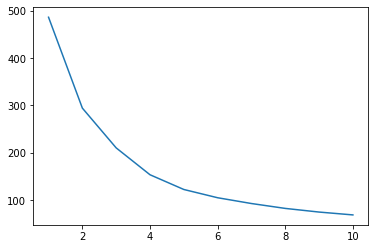

In [75]:
def elbow_loss(data):
    # Normalize the data first
    scaler = StandardScaler()
    if 'location' in data.columns:
        data = data.drop(['location'], axis=1)
    
    data = scaler.fit_transform(data)   

    # Fit cluster number use elbow method
    costs = []
    clusters = [i for i in range(1, 11)]

    for n in clusters:
        kmeans = KMeans(n_clusters=n, init='k-means++', n_init=20)
        kmeans.fit(data)
        costs.append(kmeans.inertia_)

    plt.plot(clusters, costs)
    
elbow_loss(full_country_data)

In [7]:
def cluster(data, clusters):    
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init=20)
    if 'location' in data.columns:
        data = data.drop(['location'], axis=1)
        
    kmeans.fit(data)
    
    labels = kmeans.labels_
    print(len(labels))
    print(labels)

    data['cluster'] = labels
    country_cluster = data[['cluster']]

    return country_cluster

In [76]:
country_cluster = cluster(full_country_data, 5)
country_cluster.head()

162
[0 3 1 3 0 1 1 4 3 1 0 1 2 1 3 3 3 0 3 1 3 2 3 0 3 3 1 1 3 1 3 1 3 0 1 0 3
 3 1 3 0 1 3 3 1 4 1 0 3 1 2 1 1 3 0 2 1 0 1 1 0 2 2 3 3 1 3 0 3 3 1 1 1 3
 1 3 2 3 1 2 0 0 3 2 3 0 1 0 2 3 3 1 3 1 3 3 1 2 2 2 2 0 3 3 3 1 1 1 3 1 1
 3 2 3 1 4 3 1 0 3 1 1 0 2 3 3 3 3 2 3 0 1 0 1 2 3 1 1 3 3 0 1 1 2 3 1 0 3
 0 1 3 4 0 1 1 1 4 3 2 3 0 3]


,cluster
iso_code,
ALB,0
DZA,3
AND,1
ARG,3
ARM,0


# Map plot

In [30]:
def build_geodata(shapefile, data):
    map_df = gpd.read_file(shapefile)
    gdf = map_df[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
    
    # Merged is a dataframe with the columns ['ADMO_A3', 'geometry', 'location', 'cluster']
    merged = gdf.merge(country_cluster, how='outer', left_on='ADM0_A3', right_on='iso_code')
    
#     # Replace missing cluster with '-1' for color coding purposes
#     merged['cluster'].fillna(value=-1, inplace=True)
#     merged[merged['cluster'].isnull()]    # Should be empty now
    return merged

shapefile = "shape_files/ne_10m_admin_0_countries_lakes.shp"

map_df = gpd.read_file(shapefile)

In [77]:
merged = build_geodata(shapefile, country_cluster)
merged.sample(8)

,ADM0_A3,geometry,cluster
188,ISL,"MULTIPOLYGON (((-1029979.730 6945918.439, -103...",1.0
219,MLT,"MULTIPOLYGON (((1290939.117 3838398.629, 12923...",1.0
87,DJI,"POLYGON ((4060986.044 1228648.742, 4056426.151...",3.0
58,LUX,"POLYGON ((501187.069 5339353.679, 500670.870 5...",1.0
44,LTU,"MULTIPOLYGON (((2086220.070 5905626.960, 20873...",0.0
89,AUT,"POLYGON ((1402718.787 5182106.237, 1403923.515...",1.0
243,PLW,"MULTIPOLYGON (((12653587.500 756634.571, 12654...",NaN
35,BLR,"POLYGON ((1914447.145 5483372.933, 1913937.101...",2.0


In [11]:
keys = list(merged['cluster'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))
colors = [plt.cm.tab20b(x) for x in color_range]
color_dict = dict(zip(keys, colors))
color_dict[-1] = 'lightgray'

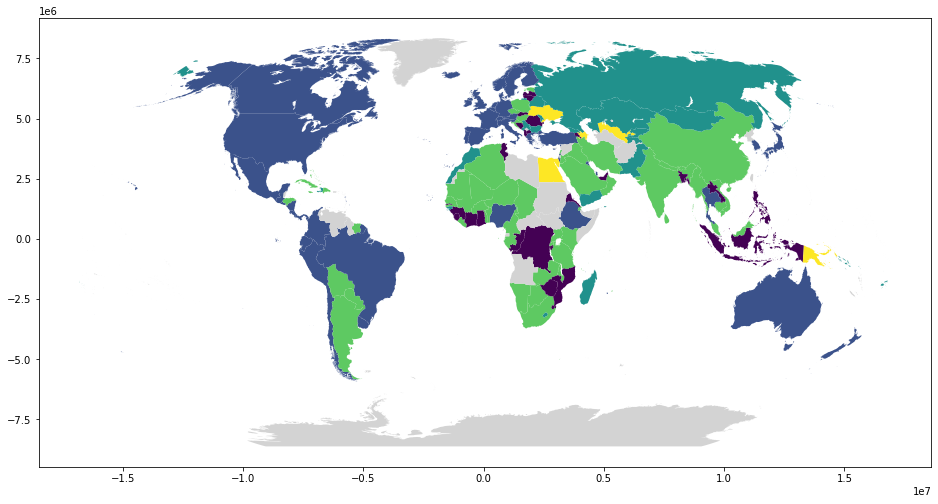

In [78]:
import mapclassify
from matplotlib.colors import LinearSegmentedColormap

ax = merged.plot(column='cluster', 
                  figsize = (16, 10),
                  missing_kwds={'color': 'lightgrey'},
                  legend=False)

plt.savefig('country_cluster.png')

,ADM0_A3,geometry,cluster
9,CHN,"MULTIPOLYGON (((7341533.511 3229629.092, 73418...",3.0


# Trying PCA

In [181]:
# Load in the data
df = dataset.copy()
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,NaN,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
3,ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
4,ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [67]:
full_country_data = clean_data(relevant_columns, dataset).drop(['location'], axis=1)
full_country_data

,population_density,median_age,aged_65_older,cardiovasc_death_rate,diabetes_prevalence,life_expectancy
iso_code,,,,,,
ALB,104.871,38.0,13.188,304.195,10.08,78.57
DZA,17.348,29.1,6.211,278.364,6.73,76.88
ARG,16.177,31.9,11.198,191.032,5.50,76.67
ARM,102.931,35.7,11.232,341.010,7.11,75.09
AUS,3.202,37.9,15.504,107.791,5.07,83.44
...,...,...,...,...,...,...
VNM,308.127,32.6,7.150,245.465,6.00,75.40
YEM,53.508,20.3,2.922,495.003,5.35,66.12
ZMB,22.995,17.7,2.480,234.499,3.94,63.89


In [68]:
def do_pca(data, retained_var=0.99):
       
    # Standardize the data to have a mean of ~0 and a variance of 1
    X_std = StandardScaler().fit_transform(data)# Create a PCA instance: pca
    
    n = len(data.columns)
    model = PCA(n_components=n)
    model.fit_transform(X_std)
    var = model.explained_variance_ratio_.cumsum()
    print(var)
                
    for i in range(n):
        if var[i] >= retained_var:
            pca = PCA(n_components=i)
    
            principalComponents = pca.fit_transform(X_std)# Plot the explained variances
            features = range(pca.n_components_)
            plt.bar(features, pca.explained_variance_ratio_, color='black')
            plt.xlabel('PCA features')
            plt.ylabel('variance %')
            plt.xticks(features)# Save components to a DataFrame
            PCA_components = pd.DataFrame(principalComponents)
            
            break
    
    return PCA_components

[0.489 0.681 0.846 0.965 0.992 1.   ]


,0,1,2,3
0,1.146013,0.233376,-0.942917,0.190699
1,-0.158078,-0.114621,-0.166979,-0.176881
2,0.583043,-0.674662,0.307872,-0.285148
3,0.384756,-0.233110,-0.676950,0.604438
4,1.993431,-1.015681,0.523403,-0.530535
...,...,...,...,...
156,0.136715,-0.110193,0.278632,0.081576
157,-2.357920,-0.065681,-0.782880,1.070434
158,-2.096199,-0.529031,0.846600,-0.352306
159,-2.396659,-0.921696,0.696392,0.380243


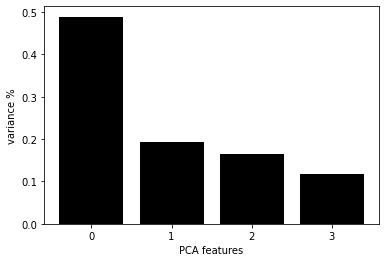

In [69]:
PCA_components = do_pca(full_country_data)
PCA_components

In [226]:
def elbow_loss_pca(data):
    loss = []
    
    ks = range(1, 10)
    for k in range(1, 10):
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters=k)

        # Fit model to samples
        model.fit(data)

        # Append the inertia to the list of inertias
        loss.append(model.inertia_)
        
    plt.plot(ks, loss, '-o', color='black')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

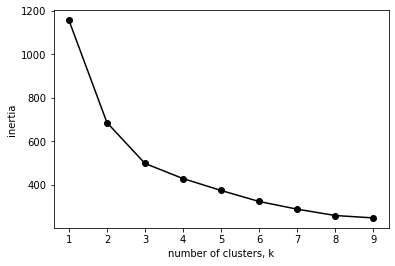

In [227]:
elbow_loss_pca(PCA_components)